In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

https://www.linkedin.com/pulse/my-2d-fea-code-python-luiz-carlos-largura-p-e-

In [2]:
# definition d'un objet element

class Node:
    id = 0
    def __init__(self, x, y, region):
        self.id = Node.id
        Node.id += 1
        self.x = x
        self.y = y
        self.region = region
        
    def __repr__(self):
        return f"Node {self.id} [{self.x},{self.y}], region = {self.region}"

class Element:
    id = 0
    def __init__(self, nodes):
        self.nodes = nodes
        self.id = Element.id
        Element.id += 1
        
    def getCoords(self):
        return np.array([[n.x,n.y] for n in self.nodes])
    
    def __repr__(self):
        return f"Element {self.id}\nNodes : {[n.id for n in self.nodes]}\nCoords : {self.getCoords()}"

def plotMesh(elements):
    
    fig, ax = plt.subplots()
    for e in elements:
        coords = e.getCoords()
        plt.fill(coords[:,0], coords[:,1], color="greenyellow", alpha=0.5, ec="k")
        for n in e.nodes:
            if n.region == 4: plt.plot(n.x, n.y, "b+")
    ax.set_aspect("equal", "box")
    plt.show()

In [3]:
# definition du maillage

N = 20
L = 100.0
xCoords = np.linspace(0.0, L, N+1)
dof = (N+1)*(N+1)

# regions index
omega, bot, right, top, left = 1, 2, 3, 4, 5
Ttop, Tbot = 10.0, 30.0

Node.id = 0
nodesCoord = np.array([[[x,y] for x in xCoords] for y in xCoords]).reshape((dof,2))
nodes = [Node(coord[0], coord[1], 2 if coord[1] == 0.0 else 4 if coord[1] == L else 1) for coord in nodesCoord]

Element.id = 0
elements = []
for i in range(N*N):
    nodesIdx = [i+i//N,i+1+i//N,i+N+2+i//N,i+N+1+i//N]
    elements.append(Element([nodes[n] for n in nodesIdx]))

Element 0
Nodes : [0, 1, 22, 21]
Coords : [[0. 0.]
 [5. 0.]
 [5. 5.]
 [0. 5.]]
Node 1 [5.0,0.0], region = 2


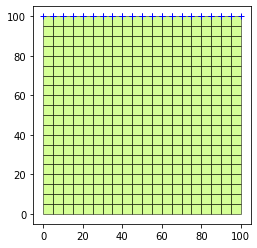

In [4]:
print(elements[0])
print(elements[0].nodes[1])
plotMesh(elements)

In [5]:
# définition des interpolateurs (P1 : linéaire) et de ses dérivées partielles
phi = [
    lambda u,v : 0.25*(1-u)*(1-v), # (-1,-1)
    lambda u,v : 0.25*(1+u)*(1-v), # (+1,-1)
    lambda u,v : 0.25*(1+u)*(1+v), # (+1,+1)
    lambda u,v : 0.25*(1-u)*(1+v), # (-1,+1)
]

duphi = [
        lambda u,v : -0.25*(1-v),   # (-1,-1)
        lambda u,v : 0.25*(1-v),    # (+1,-1)
        lambda u,v : 0.25*(1+v),   # (-1,+1)
        lambda u,v : -0.25*(1+v),   # (+1,+1)
]
dvphi = [
        lambda u,v : -0.25*(1-u),   # (-1,-1)
        lambda u,v : -0.25*(1+u),   # (+1,-1)
        lambda u,v : 0.25*(1+u),    # (-1,+1)
        lambda u,v : 0.25*(1-u),    # (+1,+1)
]

gradPhi = [
        lambda u,v: np.array([duphi[i](u,v), dvphi[i](u,v)])
        for i in range(4)
]

# fonction retournant l'interpolateur selon les 4 fonctions phi pour les 4 valeurs aux noeuds X
def interp(phiList, X):
    return lambda u,v : sum([phi(u,v)*x for phi,x in zip(phiList, X)])

In [6]:
# Pour chaque élément calcul:
# - du jacobien
# - de l'inverse de la matrice jacobienne

for e in elements:

    coords = e.getCoords()
    X, Y = coords[:,0], coords[:,1]

    dxdu = interp(duphi, X)
    dxdv = interp(dvphi, X)        
    dydu = interp(duphi, Y)
    dydv = interp(dvphi, Y)
    
    e.detJ = lambda u,v : dxdu(u,v)*dydv(u,v) - dxdv(u,v)*dydu(u,v)

    e.iJ = lambda u,v :  np.array(
        [[dydv(u,v), -dydu(u,v)],
        [-dxdv(u,v), dxdu(u,v)]]
    )/e.detJ(u,v)


In [7]:
# Détermination d'une règle de quadrature 

# nombre de points de quadrature (par dimension)
Nquad = 5 

# importation poids et abscices Gauss-Legendre
data = np.loadtxt(f"../quadratureRules/gl_{Nquad:02d}.tab")
w_i, xi_i = data[:,0], data[:,1] 

# Compute the 2D integral of f(u,v) over [-1,1]x[-1,1]

int2D = lambda f: sum([ sum([w1*w2 * f(xi1, xi2) for xi1,w1 in zip(xi_i, w_i)]) for xi2,w2 in zip(xi_i, w_i)])

## Problème physique

Résolution par EF de l'équation de la chaleur:
$$
\Delta T = 0
$$
sur le milieu $\Omega$.
Avec comme conditions aux limites:
- $T = T_1$ sur le bord inférieur, noté $\partial\Omega_1$ (Dirichlet)
- $T = T_2$ sur le bord supérieur, noté $\partial\Omega_2$ (Dirichlet)
- $\partial_nT = 0$ sur les bords latéraux, noté , noté $\partial\Omega_3$  (Neuman)

La forme variationelle est ainsi, en notant u le champ de T et v la fonction test:
$$
\int_\Omega\nabla u\nabla v = \int_{\partial\Omega_3}v\partial_n u = 0, \forall v \in V = \{v\in H^1_0(\Omega)\setminus v = 0 \text{ sur } \partial\Omega_1\cup\partial\Omega_2\}
$$

Par discrétisation on se ramène ainsi au système algébrique: $$ u_iK_{ij} = 0$$ avec $u_i$ les valeurs aux noeuds libres. $K_{ij}$ étant issue de l'assemblage des matrice de rigidité élémentaires:
$$
K^e_{ij}  = \int_{\Omega_e}\nabla\Phi_j\nabla\Phi_i
$$

On étend le système aux noeuds fixés: $$ u_iK_{ij} = F_i$$ avec $F_i$ nul pour i noeud libre et sino égal à la valeur de la condition de Dirichlet.


In [8]:
# Calcul des matrices élémentaires locales -> à optimiser

for e in tqdm(elements):

    e.Ke = np.zeros((4,4))
    
    for i in range(4):
        for j in range(4):

            fk = lambda u,v: (e.iJ(u,v)@gradPhi[i](u,v))@(e.iJ(u,v)@gradPhi[j](u,v))*e.detJ(u,v)
            e.Ke[i,j] = int2D(fk)

100%|██████████| 400/400 [00:12<00:00, 32.21it/s]


In [11]:
# Calcule des matrices globales -> à optimiser
K = np.zeros((dof,dof))
M = np.zeros((dof,dof))
F = np.zeros(dof)

for e in elements:
    for (i,n1) in enumerate(e.nodes):
        for (j,n2) in enumerate(e.nodes):
            K[n1.id,n2.id] += e.Ke[i,j]
            M[n1.id,n2.id] += e.Me[i,j]

In [12]:
# Conditions aux limites

for n in nodes:
    if n.region == bot:
        K[n.id,:] = 0
        K[n.id, n.id] = 1
        F[n.id] = Tbot
    if n.region == top:
        K[n.id,:] = 0
        K[n.id, n.id] = 1
        F[n.id] = Ttop

In [86]:
# CALCUL STATIQUE : EQUATION CHALEUR
U = np.zeros(dof)
U = np.linalg.solve(K, F)

In [88]:
%matplotlib widget
# plt.plot(U[::N], "+")
plt.imshow(U.reshape((N+1,N+1)))
plt.colorbar()

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …